# Импортируем нужные библиотеки

In [ ]:
import os
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import keras
import cv2

# Подключаем гугл диск с датасетами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загружаем данные

In [ ]:

# получаем файлы в нужном порядке
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
    
# определяем размер изображения
SIZE = 256
high_img = []

path = '/content/drive/MyDrive/ml/dataset/Raw Data/high_res/'
files = os.listdir(path)
files = sorted_alphanumeric(files)
DATASET_SIZE = 855

for i in tqdm(files):
    if '(' in i:
      continue
    if i == f'{DATASET_SIZE}.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv читает картинки в RGB формате, поэтому конвертируем в RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # изменяем размер изображения
        img = cv2.resize(img, (SIZE, SIZE))A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

Schematically, the following Sequential model:
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

low_img = []
path = '/content/drive/MyDrive/ml/dataset/Raw Data/low_res/'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):
     if '(' in i:
        continue
     if i == f'{DATASET_SIZE}.jpg':
        break
     if re.match(i, r'[(]') :
        pass  
     else: 
        img = cv2.imread(path + '/'+i,1)

        # изменяем размер изображения
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:07<00:00, 107.22it/s]


# Визуализация данных

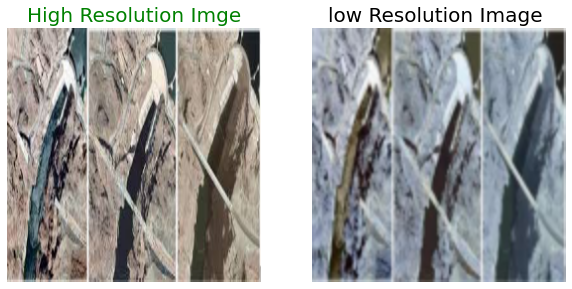

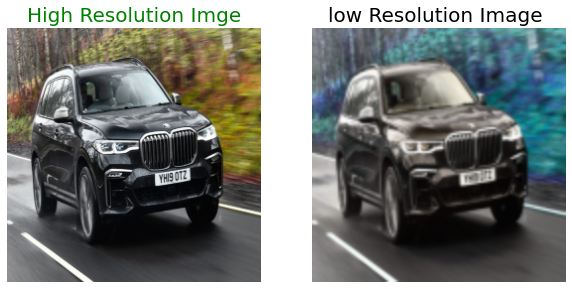

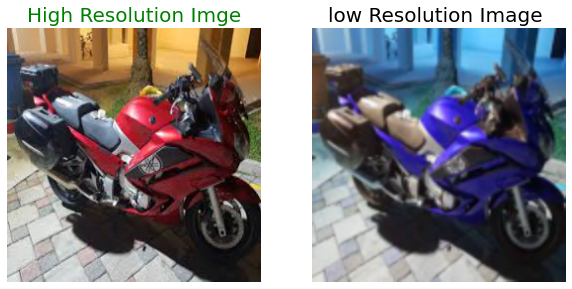

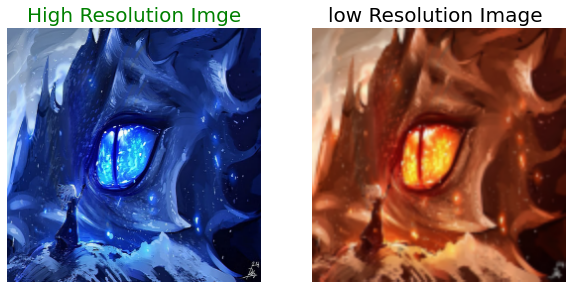

In [ ]:
for i in range(4):
    a = np.random.randint(0,DATASET_SIZE)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

# Нарезка и изменение формы изображений

In [ ]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


# Определение модели

In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_40 (Sequential)     (None, 128, 128, 12  3584        ['input_5[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_41 (Sequential)     (None, 64, 64, 128)  147584      ['sequential_40[0][0]']          
                                                                                            

# Компиляция

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

# Fitting model

In [ ]:
model.fit(train_low_image, train_high_image, epochs = 7, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/12
700/700 [==============================] - 465s 662ms/step - loss: 0.0428 - acc: 0.7237 - val_loss: 0.0292 - val_acc: 0.8112
Epoch 2/12
700/700 [==============================] - 463s 662ms/step - loss: 0.0255 - acc: 0.8038 - val_loss: 0.0218 - val_acc: 0.8520
Epoch 3/12
700/700 [==============================] - 461s 659ms/step - loss: 0.0234 - acc: 0.8162 - val_loss: 0.0219 - val_acc: 0.7935
Epoch 4/12
700/700 [==============================] - 463s 661ms/step - loss: 0.0220 - acc: 0.8253 - val_loss: 0.0230 - val_acc: 0.8060
Epoch 5/12
700/700 [==============================] - 462s 660ms/step - loss: 0.0203 - acc: 0.8424 - val_loss: 0.0210 - val_acc: 0.7920
Epoch 6/12
700/700 [==============================] - 461s 658ms/step - loss: 0.0197 - acc: 0.8423 - val_loss: 0.0207 - val_acc: 0.8597
Epoch 7/12
700/700 [==============================] - 455s 649ms/step - loss: 0.0198 - acc: 0.8352 - val_loss: 0.0284 - val_acc: 0.7451
Epoch 8/12
700/700 [============================

# Визуализация прогноза

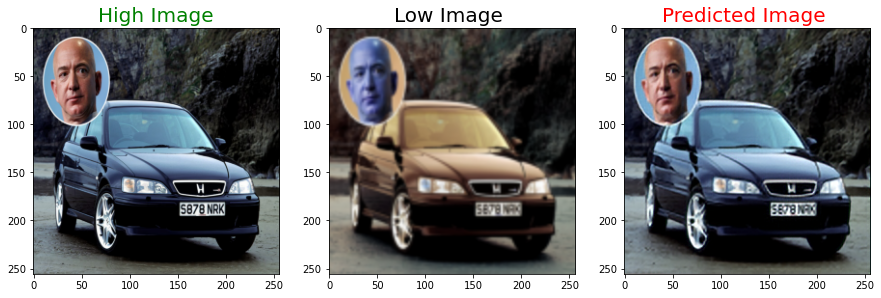

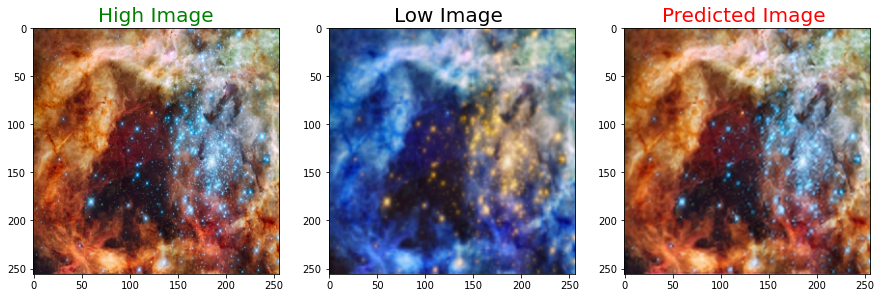

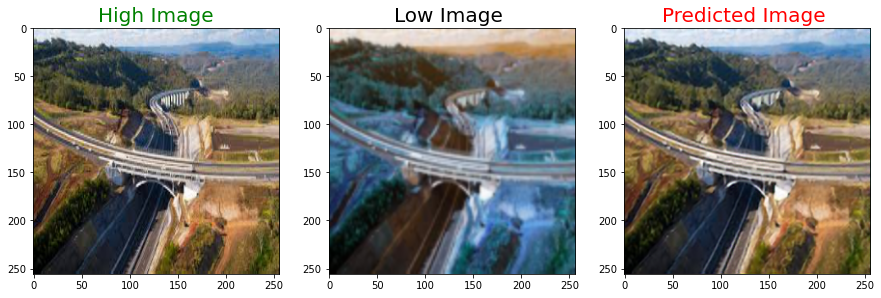

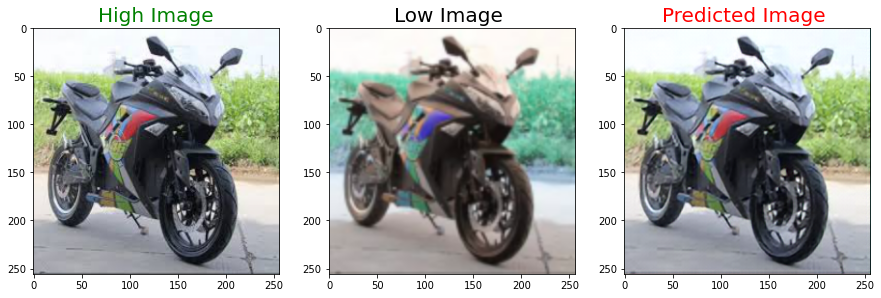

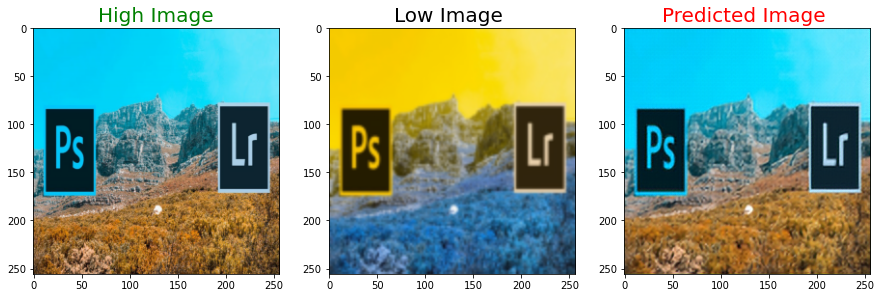

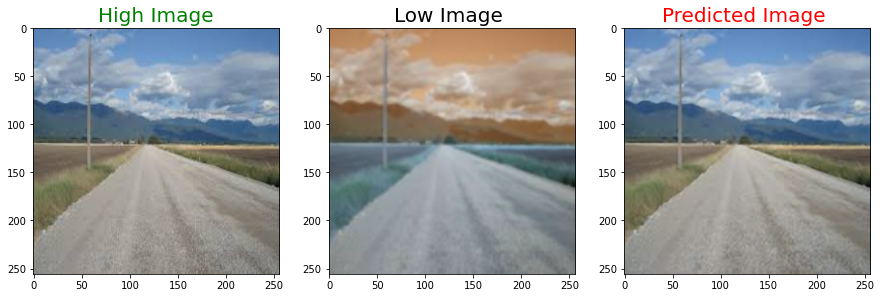

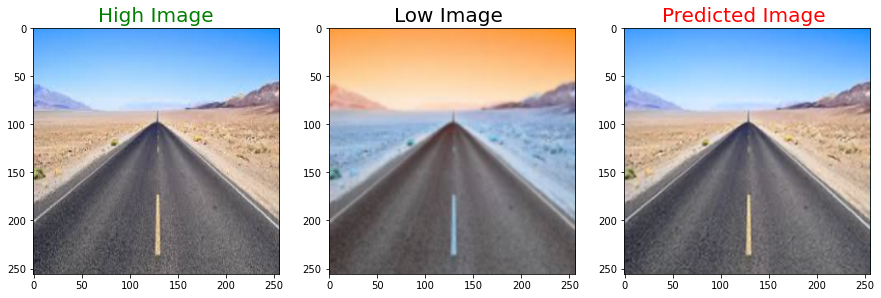

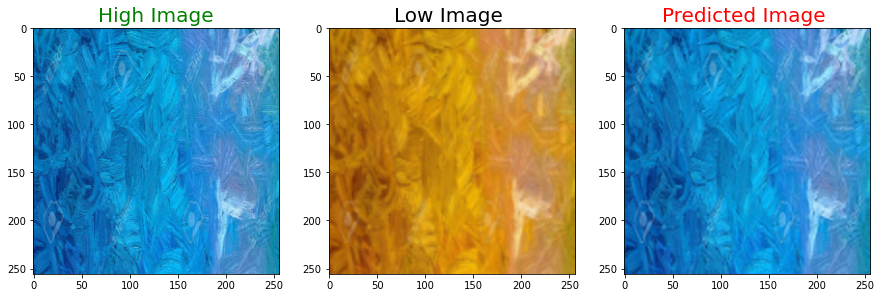

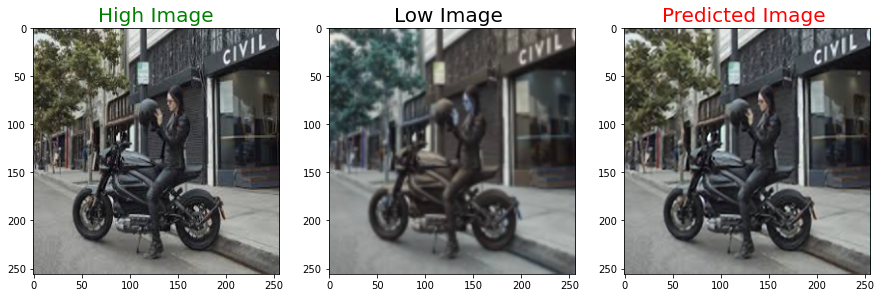

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

# Сохранение модели

In [ ]:
model.save("final_model_v3.h5")

In [ ]:
!ls

final_model_v2.h5  final_model_v3.h5  HR  LR
